In [52]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pmdarima as pm 
from pmdarima import model_selection 
from sklearn.metrics import mean_squared_error 
from math import sqrt 
import pmdarima as pm 
from pmdarima import model_selection, pipeline, arima
import statsmodels.api as sm 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import root_mean_squared_error
import matplotlib.dates as mdates

# Data management

In [53]:
file_P = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[(df_data['PriceArea']=="DK2")]
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)

# Convert the 'HourUTC' column to datetime if it's not already
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])

# Set the start and end dates
start_date = pd.Timestamp('2023-10-01 00:00:00')
end_date = pd.Timestamp('2023-12-31 23:00:00')

#merge dataframes
df_merged = pd.merge(df_prices, df_data, on="HourUTC")

# Filter the data and reset indec
# prices = df_prices
# df_prices = df_prices[(df_prices['HourUTC'] >= start_date) & (df_prices['HourUTC'] <= end_date)]
# df_prices = df_prices.reset_index(drop=True)

# Split data into training and testing sets
data = df_merged[(df_merged['HourUTC'].dt.date >= start_date.date()) & (df_merged['HourUTC'].dt.date <= end_date.date())]
data = data.reset_index(drop=True)

prices = data['SpotPriceDKK'].values

train, test = model_selection.train_test_split(prices, test_size=744) # 744 hours in december



# Task 1

#### Plot values of test and train and test seasonality

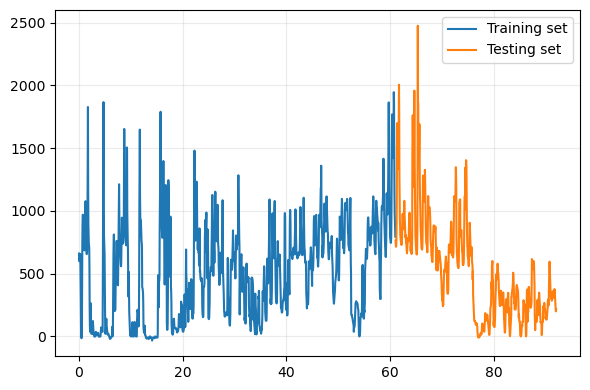

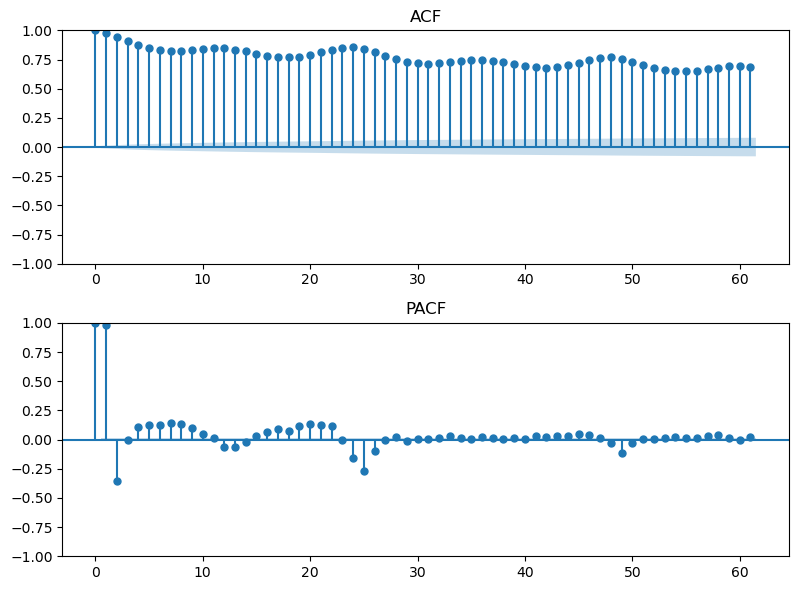

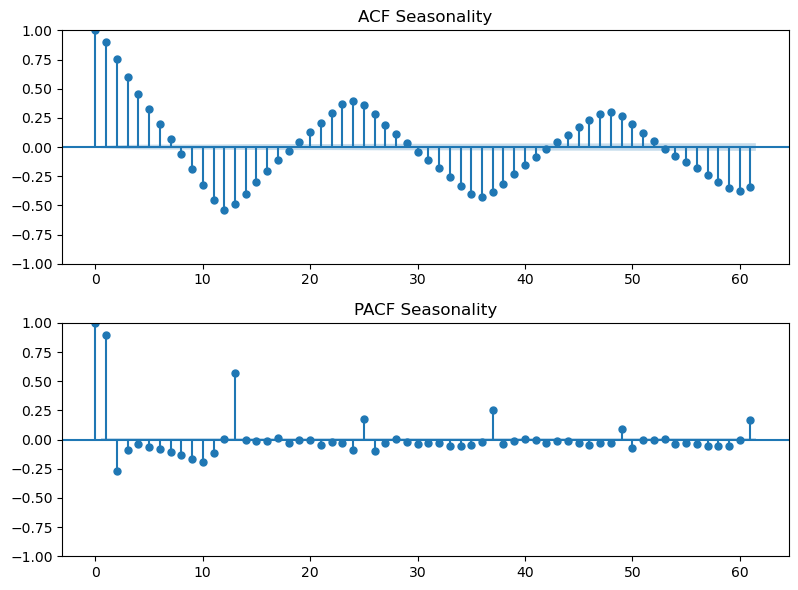

In [54]:
n_train = len(train)
n_test = len(test)
n_data = len(data)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train+1)/24, train)
plt.plot(np.arange(n_train+1,n_data+1)/24, test)
plt.legend(["Training set", "Testing set"])
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Determine lag for ACF/PACF plots
lag = 12*5+1

# Check ACF plot
sm.graphics.tsa.plot_acf(df_prices["SpotPriceDKK"], title = "ACF", lags=lag, ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(df_prices["SpotPriceDKK"], title = "PACF", lags=lag, ax=ax[1])

plt.tight_layout()
plt.show()
# from the previously plot a seasonal pattern is observed, thus we will take the difference of the data with a lag of 12
prices12 = pm.utils.diff(df_prices["SpotPriceDKK"],12)

# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(prices12, lags=lag, title="ACF Seasonality", ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(prices12, lags=lag, title="PACF Seasonality", ax=ax[1])

plt.tight_layout()
plt.show()

# Task 1.1

#### Find ARIMA model

In [55]:

m_S = pm.auto_arima(train, trace = True, seasonal=True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18125.929, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=17934.451, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17927.556, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18123.930, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=17926.948, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=17927.035, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=17923.456, Time=0.18 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=17923.778, Time=0.41 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=17924.247, Time=0.39 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=17933.776, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=17849.822, Time=0.51 sec
 ARIMA(2,1,1)(1,0,0)[12

### Forecast

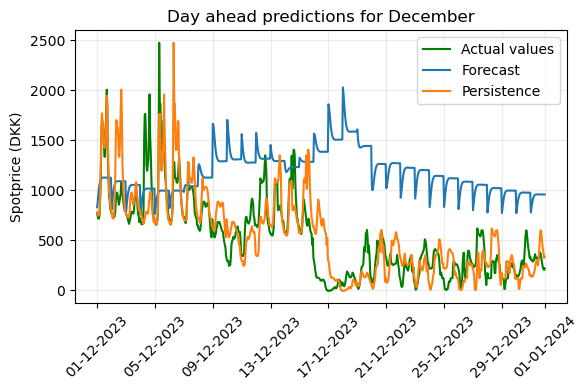

In [56]:
# Create an empty list for the day ahead forecasts
Forecasts_S = []
Persistence = []


N = int(len(test)/24)
for i in range(N):

    # Generate forecast for the next 24-hour period
    frc_S = m_S.predict(n_periods=24)
    
    # Append the forecast for each hour to the list
    Forecasts_S.extend(frc_S)
    
    # Update the model with new observations 
    m_S.update(test[i])  
    
    #include the Persistence model
    Persistence.extend(prices[len(train)+i*24-24:len(train)+i*24])
   
#Plotting
dates = data["HourUTC"][-744:]
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(dates, test, color = "green")
plt.plot(dates, Forecasts_S)
plt.plot(dates, Persistence)
plt.title("Day ahead predictions for December")
plt.legend(["Actual values", "Forecast", "Persistence"])
plt.ylabel("Spotprice (DKK)")
date_format = mdates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.grid(alpha=0.25)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### RMSE

In [57]:
# Calculate the RMSE for the seasonal persistence forecasts
RMSE_S = sqrt(mean_squared_error(test, Forecasts_S))

RMSE_Persistence = sqrt(mean_squared_error(test, Persistence))

print("RMSE for the seasonal forecast: ", RMSE_S)
print("RMSE for the persistence forecast: ", RMSE_Persistence)

RMSE for the seasonal forecast:  809.3143377862241
RMSE for the persistence forecast:  248.88782621366917


# Task 1.2

#### Deciding variables

In [58]:
Corr = data.drop(columns=["HourUTC","HourDK","PriceArea"]).corr(method='pearson')
Corr = Corr.round(2)
print(Corr)

                            SpotPriceDKK  CentralPowerMWh  LocalPowerMWh  \
SpotPriceDKK                        1.00             0.38           0.70   
CentralPowerMWh                     0.38             1.00           0.55   
LocalPowerMWh                       0.70             0.55           1.00   
CommercialPowerMWh                  0.53             0.40           0.56   
LocalPowerSelfConMWh               -0.13             0.07           0.00   
OffshoreWindLt100MW_MWh            -0.39            -0.17          -0.17   
OffshoreWindGe100MW_MWh            -0.45            -0.11          -0.23   
OnshoreWindLt50kW_MWh              -0.59            -0.28          -0.37   
OnshoreWindGe50kW_MWh              -0.61            -0.19          -0.37   
HydroPowerMWh                        NaN              NaN            NaN   
SolarPowerLt10kW_MWh               -0.07            -0.22          -0.13   
SolarPowerGe10Lt40kW_MWh           -0.08            -0.22          -0.14   
SolarPowerGe

#### Model

In [59]:

n_train = len(train)
n_test = len(test)
n_data = len(data)
# Get the training/testing datasets of the predictors
X_train, X_test = model_selection.train_test_split(data[["CentralPowerMWh","LocalPowerMWh"]], test_size=744)

# Define X_train_ar 
n = n_train
X_train_ar = np.column_stack([np.arange(1, n+1), X_train])

#Use pipeline to create model
pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24, k = 12)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=20, 
                              suppress_warnings=True))])

pipe.fit(train, X = X_train_ar)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20635.823, Time=3.60 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19497.320, Time=2.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=19160.776, Time=2.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=18845.487, Time=2.91 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=18774.515, Time=2.68 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=18662.174, Time=2.95 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.81 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=17672.245, Time=2.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=17677.229, Time=2.72 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=17725.473, Time=2.72 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=17705.114, Time=2.78 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17641.005, Time=2.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=17695.262, Time=2.78 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=17785.436, Time=2.66 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=17769.954, Time=3.03 sec
 

Pipeline(steps=[('fourier', FourierFeaturizer(k=12, m=24)),
                ('arima',
                 AutoARIMA(error_action='ignore', maxiter=20, seasonal=False,
                           stepwise=False, trace=1))])

 #### Forecast

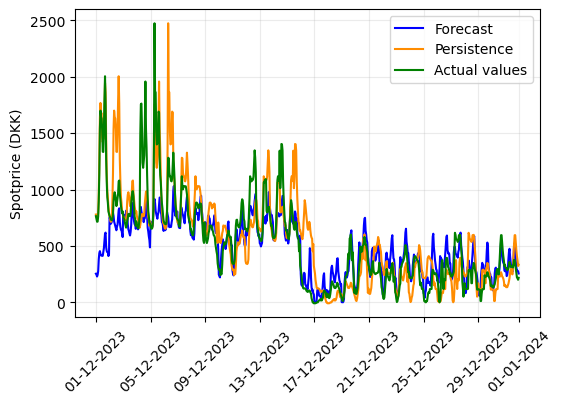

RMSE for daily persistence:  248.88782621366917
RMSE for forecasts:  253.28483875029636


<Figure size 640x480 with 0 Axes>

In [60]:
#Create empty arrays

rolling_forecast = []
Persistence   = []

dataset = data['SpotPriceDKK']

N = int(len(test)/24)

for i in range(N):

    # Create X_f for the forecasting period
    X_f = np.column_stack([np.arange(1, 24+1), 
                           X_test[i*24:(i+1)*24]])

    forecast = pipe.predict(n_periods=24, X = X_f)
    
    rolling_forecast.extend(forecast)

    pipe.update(test[i*24:(i+1)*24], X = X_f)
    Persistence.extend(dataset[len(train)+i*24-24:len(train)+(i+1)*24-24])
    

#Plotting
rolling_forecast = [0 if x < 0 else x for x in rolling_forecast]

plt.figure(figsize=(6, 4), dpi=100)

plt.plot(dates, rolling_forecast, color = "blue")
plt.plot(dates, Persistence, color = "darkorange")
plt.plot(dates, test, color = "green")
plt.legend(["Forecast","Persistence" , "Actual values"], loc = "upper right")
plt.grid(alpha=0.25)
plt.ylabel("Spotprice (DKK)")
date_format = mdates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

plt.show()
plt.tight_layout()

RMSE_P24 = root_mean_squared_error(Persistence, test)
RMSE_F = root_mean_squared_error(rolling_forecast, test)

print("RMSE for daily persistence: ", RMSE_P24)
print("RMSE for forecasts: ", RMSE_F)

# Task 2

## Task 2.1

Epoch 1/30


c:\Users\willi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0276 - val_loss: 0.0015
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - val_loss: 0.0016
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - val_loss: 0.0018
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 9.9486e-04
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 8.8605e-04
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 8.0035e-04
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 8.1842e-04
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 7.8276e-04
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

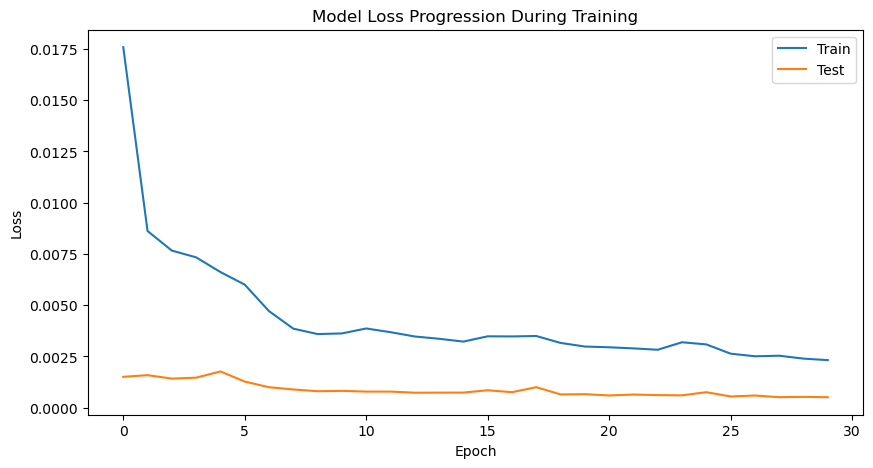

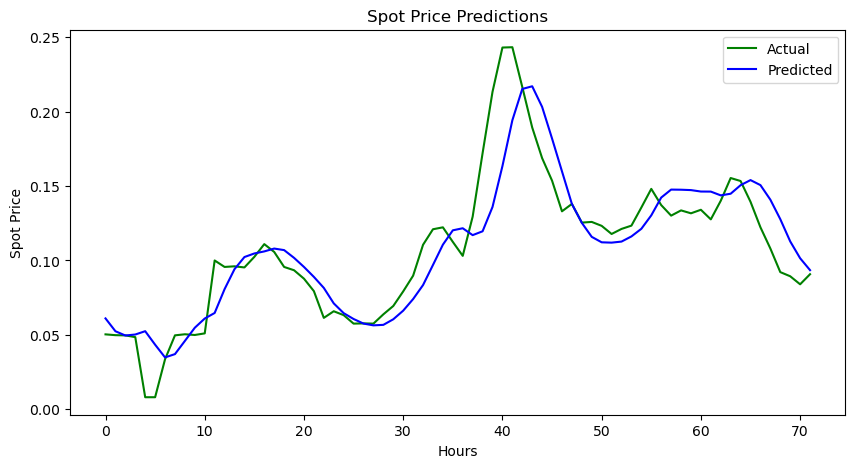

In [70]:
start_date = pd.Timestamp('2023-12-01 00:00:00')
end_date = pd.Timestamp('2023-12-31 23:00:00')
df_prices = df_prices[(df_prices['HourUTC'].dt.date >= start_date.date()) & (df_prices['HourUTC'].dt.date <= end_date.date())]

scaler = MinMaxScaler(feature_range=(0, 1))
df_prices['SpotPriceDKK'] = scaler.fit_transform(df_prices[['SpotPriceDKK']])

look_ahead = 1

# Define a function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data = data.values  # Ensure 'data' is a NumPy array
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 24  # Using 24 hours of data to predict the next hour
X, y = create_sequences(df_prices['SpotPriceDKK'], sequence_length)

# Splitting data into training and testing sets
train_size = int(len(X) * 0.9)  # 90% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# X_train and X_test for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True),  
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict the test data
predictions = model.predict(X_test)

## To retrieve unnormalized predicted values
Selected_rows = predictions[::look_ahead,:] # Collect predictions values into 1 column

dataframe = pd.DataFrame(Selected_rows) # Create new dataframe
dataframe.reset_index(drop=True, inplace=True)
stacked_values = dataframe.stack()

pred_together = pd.DataFrame(stacked_values, columns=['SpotPriceDKK']) # convert into a single column
pred_together.reset_index(drop=True, inplace=True)

pred_together_rev = scaler.inverse_transform(pred_together) # Inverse transform the scaled values

## To retrieve unnormalized test values
Selected_rows = y_test[::look_ahead]

dataframe = pd.DataFrame(Selected_rows)
dataframe.reset_index(drop=True, inplace=True)
stacked_values = dataframe.stack()

test_together = pd.DataFrame(stacked_values, columns=['SpotPriceDKK'])
test_together.reset_index(drop=True, inplace=True)

test_together_rev = scaler.inverse_transform(test_together)

## Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_together_rev, pred_together_rev))
print('Test RMSE: %.3f' % rmse)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the test data and the predictions
train_results = pd.DataFrame(data={'Actual': test_together_rev.flatten(), 'Predicted': pred_together_rev.flatten()})
plt.figure(figsize=(10, 5))
plt.plot(train_results['Actual'], color='green')
plt.plot(train_results['Predicted'], color='blue')
plt.title('Spot Price Predictions')
plt.ylabel('Spot Price')
plt.xlabel('Hours')
plt.legend(['Actual', 'Predicted'])
plt.show()


## Task 2.2

In [66]:
# Adjusting column names according to the data
#df_data = df_data[df_data['PriceArea'] == 'DK2']

start_date = pd.Timestamp('2023-12-01 00:00:00')
end_date = pd.Timestamp('2023-12-31 23:00:00')
df_data =  df_data[(df_data['HourUTC'].dt.date >= start_date.date()) & (df_data['HourUTC'].dt.date <= end_date.date())]


df_data['DayOfWeek'] = df_data['HourUTC'].dt.dayofweek  # Adding day of the week as an exogenous variable
df_data = df_data[['HourUTC', 'OffshoreWindGe100MW_MWh', 'OnshoreWindGe50kW_MWh', 'SolarPowerGe40kW_MWh', 'DayOfWeek']]

df_merged = pd.merge(df_prices, df_data, on='HourUTC')

# Normalizing
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['SpotPriceDKK', 'OffshoreWindGe100MW_MWh', 'OnshoreWindGe50kW_MWh', 'SolarPowerGe40kW_MWh', 'DayOfWeek']

df_merged[features] = scaler.fit_transform(df_merged[features])

# Define a function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    data = data.to_numpy()  # Convert DataFrame to numpy array for processing
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Creating sequence
sequence_length = 24
X, y = create_sequences(df_merged[features], sequence_length)

# Splitting data into training and testing sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Checing the input shape is correctly specified
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Rebuild the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and calculate RMSE
predictions = model.predict(X_test)

"""
Insert the RMSE calulcation here................

"""

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Change this to the inverse transformed values
"""# Plotting the test data and the predictions
train_results = pd.DataFrame(data={'Actual': test_together_rev.flatten(), 'Predicted': pred_together_rev.flatten()})
plt.figure(figsize=(10, 5))
plt.plot(train_results['Actual'], color='green')
plt.plot(train_results['Predicted'], color='blue')
plt.title('Spot Price Predictions')
plt.ylabel('Spot Price')
plt.xlabel('Hours')
plt.legend(['Actual', 'Predicted'])
plt.show()"""


Epoch 1/30


c:\Users\willi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0449 - val_loss: 0.0075
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0016
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0010
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 9.2991e-04
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 9.6121e-04
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Task 4

### Define parameters

In [ ]:



params = {
    'Pmax': 5, #Max charging capacity 1 MW
    'n_c': 0.95, #Charging effiency
    'n_d': 0.95, #Decharging effiency
    'Cmax': 10 #Max 2 MWh storage
}

params['C_0'] = 0.5 * params['Cmax'] #SOC at start
params['C_n'] = 0.5 * params['Cmax'] #SOC at end


## Task 4.1

In [ ]:
## import the cvxpy library
import cvxpy as cp

## Define the optimizer function

def Optimizer(params, p):

    import cvxpy as cp

    n = len(p)
    p_c = cp.Variable(n)
    p_d = cp.Variable(n)
    X   = cp.Variable(n)
    profit = cp.sum(p_d@p - p_c@p)
    
    constraints = [p_c >= 0, 
                   p_d >= 0, 
                   p_c <= params['Pmax'], 
                   p_d <= params['Pmax']]
    constraints += [X >= 0, X <= params['Cmax']]
    constraints += [X[0]==params['C_0'] + p_c[0]*params['n_c'] - p_d[0]/params['n_d']]
    
    constraints += [X[1:] == X[:-1] + p_c[1:]*params['n_c'] - p_d[1:]/params['n_d']]
    
    constraints += [X[n-1]>=params['C_n']]
    
    problem = cp.Problem(cp.Maximize(profit), constraints)
    problem.solve(solver=cp.ECOS)
    
    return profit.value, p_c.value, p_d.value, X.value

# Convert prices to DKK/kWh
test = test/1000
profitOpt, p_cOpt, p_dOpt, XOpt = Optimizer(params, test)

print("Profit using battery in december using actual values is:", profitOpt, "DKK")

Profit using battery in december using actual values is: 0.1379163944457994 ,DKK


### Use the forecasting model you developed and has the highest accuracy (ARIMA or LSTM) for day-ahead prediction

In [ ]:
## We use ARIMA model m_S to predict the spot prices for the month of December 2023 and calculate the profit

# Convert prices to DKK/kWh
Forecasts_S = np.array(Forecasts_S)
Forecasts_S = Forecasts_S/1000

profitOpt, p_cOpt, p_dOpt, XOpt = Optimizer(params, Forecasts_S)
print("Profit using battery in december using forecasted values is:", profitOpt, ",DKK")

## Now also use the LSTM model and compare the results

# .............................................

Profit using battery in december using forecasted values is: 41.83857942094062 ,DKK


## Task 4.2

### Use the persistence model for day-ahead predictions

In [ ]:
## Now we use the persistence data to predict the profit from optimizing the battery

# Convert prices to DKK/kWh
Persistence = np.array(Persistence)
Persistence = Persistence/1000

profitOpt, p_cOpt, p_dOpt, XOpt = Optimizer(params, Persistence)
print("Profit using battery in december using persistence forecast is:", profitOpt, ",DKK")

Profit using battery in december using persistence forecast is: 148.30777678597593 ,DKK


##